In [1]:
import pickle5 as pickle
import os
import os.path as osp
import geopandas as gpd
import pandas as pd
import numpy as np
from imageio import imread
import itertools as it
from matplotlib import pyplot as plt
import torch

In [49]:
result_path = '/home/fiona/birdMigration/data/model_performance/abm_repeated_training/conservation=True_recurrent=True_embedding=0_timesteps=6'
result_path = '/home/fiona/birdMigration/data/model_performance/test_gnn3'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_repeated_training_test4/conservation=True_recurrent=True_embedding=0_timesteps=6'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_multiple_year_training/conservation=False_recurrent=True_embedding=0_timesteps=15'

abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'

with open(osp.join(result_path, 'outfluxes_G_mlp.pickle'), 'rb') as f:
    outfluxes = pickle.load(f)
with open(osp.join(result_path, 'outfluxes_abs_G_linear+sigmoid.pickle'), 'rb') as f:
    outfluxes_abs = pickle.load(f)
with open('/home/fiona/birdMigration/data/model_performance/abm_multiple_year_training/conservation=True_recurrent=True_embedding=0_timesteps=6/nights.pickle', 'rb') as f:
    nights = pickle.load(f)
    
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
N = len(voronoi)

In [33]:
def find_target(nights, t):
    for nidx, n in enumerate(nights):
        if t in n:
            tidx = np.where(np.array(n)==t)[0][0]
            return nidx, tidx

In [56]:
ml_fluxes = []
abm_fluxes = []
for nidx, night in enumerate(nights[:-1]):
    ml_fluxes.append(outfluxes_abs[nidx][:, :, :len(night)].detach().numpy())
    abm_fluxes.append(np.stack([np.load(osp.join(abm_path, 'outfluxes_abs', f'{tidx}.npy'))[:N, :N] for tidx in night], axis=-1))
    
ml_fluxes = np.concatenate(ml_fluxes, axis=-1) * 2000
abm_fluxes = np.concatenate(abm_fluxes, axis=-1)
max_flux = max(ml_fluxes.max(), abm_fluxes.max())

[(-50, 1615.0),
 Text(0, 0.5, 'inferred flux'),
 (-50, 1615.0),
 Text(0.5, 0, 'true (simulated) flux')]

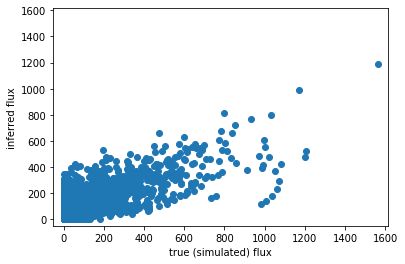

In [61]:
fig, ax = plt.subplots()
ax.scatter(abm_fluxes.flatten(), ml_fluxes.flatten())
margin=50
ax.set(xlabel='true (simulated) flux', ylabel='inferred flux', xlim=(0-margin,max_flux+margin), ylim=(0-margin,max_flux+margin))

In [42]:
for idx, radar in enumerate(voronoi.radar):
    print(f'outflux for radar {radar}')
    idx_fluxes = torch.cat([night_fluxes[idx, :, :] for night_fluxes in outfluxes.values()], dim=-1)
    mean_fluxes = idx_fluxes.mean(-1).detach().numpy()
    std_fluxes = idx_fluxes.std(-1).detach().numpy()
    
    total = 0
    for jdx, flux in enumerate(mean_fluxes):
        if flux > 0:
            total += flux
            print(voronoi.radar.iloc[jdx], flux, '+/-', std_fluxes[jdx])
    print(f'total mean flux: {total} \n')
#outfluxes

outflux for radar DE/MEM
DE/MEM 0.7897293 +/- 0.030117407
DE/ISN 6.0537637e-05 +/- 9.06491e-05
DE/TUR 1.1105368e-09 +/- 4.3649866e-09
DE/FBG 0.06167602 +/- 0.02265862
total mean flux: 0.851465857574156 

outflux for radar DE/ISN
DE/MEM 0.08355118 +/- 0.023851808
DE/ISN 0.7936281 +/- 0.026407998
DE/TUR 3.6769476e-12 +/- 2.0219888e-11
DE/EIS 5.8377068e-09 +/- 3.2102097e-08
total mean flux: 0.8771792857648227 

outflux for radar DE/ESS
DE/ESS 0.7358612 +/- 0.03349697
DE/OFT 0.010145811 +/- 0.01594986
BE/ZAV 0.047965083 +/- 0.01716918
DE/NHB 0.12956147 +/- 0.05597511
DE/HNR 1.4740243e-05 +/- 4.5755813e-05
DE/FLD 0.0037461636 +/- 0.007885534
DE/EMD 1.0709701e-08 +/- 2.7852545e-08
NL/DBL 3.2074565e-10 +/- 8.3350055e-10
total mean flux: 0.9272944606465026 

outflux for radar DE/PRO
DE/PRO 0.7312247 +/- 0.04494367
DE/UMD 0.059151307 +/- 0.017828533
DE/ROS 9.572613e-10 +/- 3.7010168e-09
DE/DRS 0.14191103 +/- 0.050979782
total mean flux: 0.9322870532310116 

outflux for radar DE/OFT
DE/ESS 1.336